# Experimenting with Cleaning, Clustering & Summarization Pipelines

### To do (technical)
- Implement date windows on my corpus loader function

In [1]:
import os
import re
import json
import hdbscan

import numpy as np
import pandas as pd
import networkx as nx

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from lib.helper import *
import lib.embedding_models as reps

from importlib import reload

%matplotlib inline

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "C:/Users/Martin/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "bing"

## 0.  Build Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

### First, get a list of all the news dumps created so far

In [3]:
corpus = corpus_loader(storage_path, corpus_type)

Total files: 62
Loading file: bing_corpus_2019-09-05_2135.json
Loading file: bing_corpus_2019-09-06_0019.json
Loading file: bing_corpus_2019-09-06_1221.json
Loading file: bing_corpus_2019-09-07_0019.json
Loading file: bing_corpus_2019-09-07_1221.json
Loading file: bing_corpus_2019-09-08_0019.json
Loading file: bing_corpus_2019-09-08_1221.json
Loading file: bing_corpus_2019-09-09_0019.json
Loading file: bing_corpus_2019-09-09_1221.json
Loading file: bing_corpus_2019-09-10_0019.json
Loading file: bing_corpus_2019-09-10_1221.json
Loading file: bing_corpus_2019-09-11_0019.json
Loading file: bing_corpus_2019-09-11_1221.json
Loading file: bing_corpus_2019-09-12_0019.json
Loading file: bing_corpus_2019-09-12_1221.json
Loading file: bing_corpus_2019-09-13_0019.json
Loading file: bing_corpus_2019-09-13_1221.json
Loading file: bing_corpus_2019-09-14_0019.json
Loading file: bing_corpus_2019-09-14_1221.json
Loading file: bing_corpus_2019-09-15_0019.json
Loading file: bing_corpus_2019-09-15_2059.js

In [4]:
corpus.head()

,date,link,origin,retrieval_timestamp,source_url,summary,title
0,2019-09-05T17:32:00.0000000Z,https://www.desmoinesregister.com/story/opinio...,bing_news_api,2019-09-05 21:35:05.105002,www.desmoinesregister.com,<b>Immigration</b> raids are as devastating to...,<b>Immigration</b> raids are as devastating to...
1,2019-09-05T20:06:00.0000000Z,https://www.philstar.com/the-freeman/cebu-news...,bing_news_api,2019-09-05 21:35:05.105002,www.philstar.com,"CEBU, Philippines — The Department of Justice ...",<b>Immigration</b> told to monitor convicts: L...
2,2019-09-05T17:21:00.0000000Z,https://www.irishtimes.com/news/crime-and-law/...,bing_news_api,2019-09-05 21:35:05.106001,www.irishtimes.com,Three members of an organised crime gang were ...,Three people jailed for assisting illegal <b>i...
3,2019-09-05T20:12:00.0000000Z,https://www.correctionsone.com/immigration-det...,bing_news_api,2019-09-05 21:35:05.106001,www.correctionsone.com,"NATCHEZ, Miss. — A privately run prison in Mis...",<b>Immigration</b> agency sets new contract wi...
4,2019-09-05T19:27:00.0000000Z,https://www.nzherald.co.nz/nz/news/article.cfm...,bing_news_api,2019-09-05 21:35:05.106001,www.nzherald.co.nz,A licensed <b>immigration</b> adviser has been...,<b>Immigration</b> adviser censured and fined ...


## 1. Clean Text

By default, I'm not going to clean out all punctuation because I think it informs the POS tagger to some degree.

In [5]:
corpus['clean_text'] = corpus[['title', 'summary']].apply(lambda x: clean_text('.  '.join(x)), axis=1)

In [6]:
# Filter to only the .uk vendors
corpus = corpus[corpus['link'].str.contains(".uk/")]

In [7]:
corpus = corpus.drop_duplicates("clean_text")

In [8]:
corpus['clean_text'].head()

14    Government announces immigration plans for no ...
16    Home Secretary Priti Patel admits No Deal Brex...
28    Student film on immigration focuses on those m...
30    No deal immigration arrangements for EU citize...
31    AP EXPLAINS: What changed in 0 days of immigra...
Name: clean_text, dtype: object

In [9]:
corpus.shape

(1173, 8)

## 2.  Build Text Model (Representation, eg; word2vec, entities list...)

- Trying with the world corpus and with the bing corpus, neither worked with InferSent.  Suspect the problem lies in the PCA step, which may not be working well on this high-dimensional (vector length = 4096) form.
- Summed keywords works rather better with the world corpus.
- Summed keywords still fail the bing/home office corpus, giving me a cluster about "immigration" and a cluster for the American Supreme Court.

In [10]:
# Windows didn't play nicely with the vector datasets, Some obscure encoding problem (python in Conda
# kept trying to decode using cp1252 regardless of whatever other options I specified!)
# Solution; rewrite file and drop any characters the Windows encoder refuses to recognise.
# I shouldn't loose too much info.
#with open('./lib/InferSent/dataset/fastText/crawl-300d-2M.vec', "r", encoding="cp1252", errors="ignore") as infile:
#    with open('./lib/InferSent/dataset/fastText/crawl-300d-2M_win.vec', "wb") as outfile:
#        for line in infile:
#            outfile.write(line.encode('cp1252'))

In [11]:
#infersent = reps.InferSentModel(list(corpus['clean_text']),
#                                list(corpus['clean_text']),
#                                W2V_PATH = './lib/InferSent/dataset/fastText/crawl-300d-2M_win.vec')
#
#embeddings = infersent.get_embeddings()

In [12]:
# Whereas this worked first time!
glove = reps.GloveWordModel(list(corpus['clean_text']), list(corpus['clean_text']))

embeddings = glove.get_embeddings()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Turn that into a DF for me
embeddings_df = pd.DataFrame({"clean_text": list(embeddings.keys()),
                              "embeddings": list(embeddings.values())})

## 3. Cluster Text

This is the part where the pipelines get a little more experimental

In [14]:
embeddings_array = np.vstack(embeddings_df['embeddings'])

In [15]:
# First, PCA the data
new_dims = 20

pca = PCA(n_components=20, svd_solver='full')

embeddings_pca = pca.fit_transform(embeddings_array)

In [16]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

[0.18399722 0.11698123 0.09125415 0.08029371 0.06275676 0.04302367
 0.03518548 0.03217785 0.02568852 0.02513301 0.0208229  0.02005769
 0.01771219 0.01701875 0.01594486 0.01519946 0.0139033  0.01258101
 0.01235039 0.01204898]
[15.69264978 12.51263365 11.05139124 10.36648239  9.16475583  7.58829793
  6.86234241  6.56249719  5.86354411  5.79979875  5.27911705  5.18120833
  4.86885446  4.77259427  4.61956371  4.51029265  4.31369606  4.10344221
  4.06566006  4.01574205]


In [17]:
clusterer = hdbscan.HDBSCAN()

In [18]:
clusterer.fit(embeddings_array)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [19]:
pd.unique(clusterer.labels_)

array([ 1, -1,  0], dtype=int64)

# Clustering using Entity Detection And Network Analytics

This doesn't resolve very well for Bing, because there's a whole bunch of keywords from the original searches in there.  Suspect that's got a lot to do with the failure of the other methods too.  For the network analytics method I'm going to try removing the keywords from the table first.

In [20]:
with open("C:/Users/Martin/Dropbox/news_crow/scrape_settings.json", "r") as f:
    scrape_config = json.load(f)

search_terms = scrape_config['search_list']
search_terms = re.sub(r"[^0-9A-Za-z ]", "", " ".join(search_terms)).lower().split()
search_terms = set(search_terms)

In [21]:
search_terms

{'abuse',
 'border',
 'child',
 'domestic',
 'enforcement',
 'force',
 'home',
 'immigration',
 'international',
 'office',
 'patel',
 'priti',
 'secretary',
 'students',
 'uk',
 'windrush'}

In [22]:
test = reps.NounAdjacencyModel(corpus['clean_text'], corpus['clean_text'])

In [23]:
nouns_df = test.table.copy()
nouns_df.head()

,thoughtless’,northumberland,higher,rachel,violence,szabo,foster,andrew,safety,victoria,...,banbury,rees,gate,lib,barry,road,frances,cortez,co,australian
clean_text,,,,,,,,,,,,,,,,,,,,,
"Government announces immigration plans for no deal Brexit. New border controls that will make it harder for serious criminals to enter the UK will be introduced in the event of a no deal Brexit, the government has announced today (4 September). In a move signalling the end of free movement in its current form, a ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Home Secretary Priti Patel admits No Deal Brexit wouldn’t end unregulated EU immigration until 2021. PRITI PATEL tonight conceded unlimited EU immigration will all-but remain in place until 2021 in a No Deal. Despite promising tougher criminal checks on migrants from October 1, the Home Office said EU citizens would be allowed unfettered access to the UK ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Student film on immigration focuses on those making district their home. A STUDENT from Bradford has helped create a short film on immigration, featuring interviews with three people who have made the district their home. Ruby Blake, 22, who studied film and TV production at Northumbria University, was inspired to make the ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
No deal immigration arrangements for EU citizens moving to the UK after Brexit. The United Kingdom will be leaving the European Union on 1 October 201. This paper sets out the immigration arrangements that will apply to EU citizens and their family members who are moving to the UK after Brexit on 1 October 201 in the event that ...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"AP EXPLAINS: What changed in 0 days of immigration accord?. MEXICO CITY (AP) - Since last year;s caravans of Central American migrants began reaching the U.S. border, the Trump administration had been increasing pressure on Mexico President Andrés Manuel López Obrador to stop the flow of migrants. But it was the ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
print(nouns_df.shape)
for each in search_terms:
    try:
        nouns_df = nouns_df.drop(each, axis="columns")
    except:
        pass

print(nouns_df.shape)

embeddings = np.asarray(nouns_df)
adjacency = np.dot(embeddings, embeddings.T)
print(np.max(adjacency))

(1173, 2277)
(1173, 2262)
21


In [25]:
# If the "lower" limit is 1, the graph has so many edges it eats ALL the memory of my desktop, even
# with just 500-ish stories to process.
upper = 100
lower = 4
G = nx.Graph()
rows, cols = np.where((upper >= adjacency) & (adjacency >= lower))
weights = [float(adjacency[rows[i], cols[i]]) for i in range(len(rows))]
edges = zip(rows.tolist(), cols.tolist(), weights)
G.add_weighted_edges_from(edges)

In [26]:
G.number_of_edges()

1836

### Actually; the below is just the long way around to get the PageRank algorithm

Except that I've accounted for edge weights less well.  Oh well, live and learn... :)

In [27]:
net_degrees = dict(nx.degree(G))
degree_df = pd.DataFrame({"node": list(net_degrees.keys()), "degree": list(net_degrees.values())})
degree_df = degree_df.sort_values("degree", ascending=False)

for index, row in degree_df.head(10).iterrows():
    article = nouns_df.reset_index().iloc[index]
    print(row['degree'], article['clean_text'])

36 Immigration centre Dungavel House issues air fresheners to fight body odour. Detainees at Scotland’s only immigration removal centre have been given air fresheners after complaining that other inmates were “too smelly”. People at Dungavel House in Lanarkshire, which can hold 250 detainees, said they were overwhelmed by ...
34 Boris Johnson blow as West Yorkshire police chief criticises use of his officers for speech backdrop. The statement said: quot;Yesterday;s visit by the Prime Minister and Home Secretary was to visit our Carr Gate training facilities, to announce the launch of the national recruitment campaign for an extra 20,000 police officers. Read more of today;s top ...
34 How your travel time to Bali to get shorter: New technology to speed up immigration. Passport ;autogate; facilities that allow Indonesian travellers and visitors from 12 countries to electronically verify themselves commenced operations on Tuesday. ;If you use the autogate system, the immigration process 

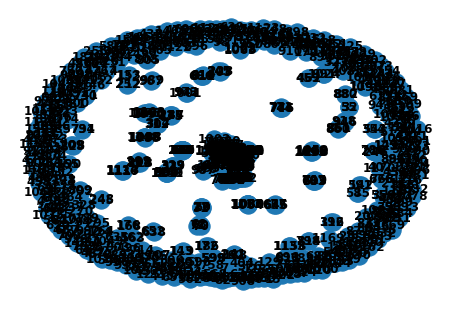

In [28]:
G_plot = nx.petersen_graph()
#plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
#plt.subplot(122)
#nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

### Cliques, worth a look?
Idea from the docs, explanation at https://en.wikipedia.org/wiki/Clique_(graph_theory)

So, cliques are allowed to overlap - should've thought of that.  Still, good preliminary results and I've found I can disambiguate the cliques to some degree by cutting out weaker links (fewer shared entities).

I should add it also appears to merely suffer from the same problems as the other clustering methods, clusters are ultimately hierarchical!

In [29]:
cliques = []
for x in nx.find_cliques(G):
    x.sort()
    cliques.append((len(x), x))

In [30]:
cliques_df = pd.DataFrame({"nodes_list": [x[1] for x in cliques],
                           "clique_size": [x[0] for x in cliques]}).\
                    sort_values("clique_size", ascending=False).\
                    reset_index()

In [31]:
cliques_df.head(20)

,index,nodes_list,clique_size
0,93,"[83, 94, 99, 107, 139, 147, 158, 218, 251, 308...",21
1,566,"[1003, 1011, 1013, 1014, 1015, 1038, 1041, 104...",11
2,568,"[1003, 1004, 1011, 1013, 1014, 1015, 1038, 104...",11
3,83,"[139, 150, 169, 171, 219, 717, 731, 804, 820, ...",10
4,37,"[61, 84, 134, 160, 239, 415, 532, 625, 645, 649]",10
5,567,"[1003, 1004, 1011, 1015, 1038, 1040, 1041, 104...",10
6,26,"[39, 61, 84, 134, 160, 415, 532, 625, 645, 649]",10
7,565,"[1003, 1004, 1013, 1014, 1015, 1038, 1042, 104...",9
8,564,"[1003, 1004, 1015, 1038, 1040, 1042, 1043, 1101]",8
9,210,"[99, 107, 218, 251, 308, 331, 511]",7


In [32]:
for node in cliques_df.iloc[0]['nodes_list']:
    article = nouns_df.reset_index().iloc[node]
    print(article['clean_text'])

Boris Johnson blow as West Yorkshire police chief criticises use of his officers for speech backdrop. The statement said: quot;Yesterday;s visit by the Prime Minister and Home Secretary was to visit our Carr Gate training facilities, to announce the launch of the national recruitment campaign for an extra 20,000 police officers. Read more of today;s top ...
Police chief ‘disappointed’ PM used officers as backdrop to political speech. John Robins with Home Secretary Priti Patel and Mr Johnson (Danny Lawson/PA) But shadow policing minister Louise Haigh was among those demanding an apology, adding: “Boris Johnson cannot even be honest with a chief constable.” “The Prime Minister and ...
Government to take steps on decision-making powers if Stormont not restored. Prime Minister Boris Johnson with Home Secretary Priti Patel during a visit to West Yorkshire, where he gave a speech about Brexit as he stood in front of lines of new police recruits. Fears were also raised by Tory former Norther

In [33]:
for node in cliques_df.iloc[1]['nodes_list']:
    article = nouns_df.reset_index().iloc[node]
    print(article['clean_text'])

Labour MP Rosie Duffield reveals she was a domestic abuse victim in a ;moving and horrifying account; to Parliament. Labour MP Rosie Duffield has revealed she was a victim of domestic abuse in a moving speech in the House of Commons. The MP for Canterbury told how she had been coercively controlled and psychologically abused as Parliament debated the domestic abuse bill ...
Labour MP Rosie Duffield opens up about being victim of domestic abuse in emotional Commons speech. Ms Duffield is comforted by friends and colleagues after giving an emotional speech about being the victim of domestic abuse (Photo: parliament TV) Labour MP Rosie Duffield has revealed she was ...
MP shares with Commons her personal experience of domestic abuse. An MP has urged others to come forward if it is safe for them to do so after sharing during a Commons debate her own experience of coercive control. Canterbury MP Rosie Duffield received a standing ovation after she gave an emotional speech about a ...
MP sha

In [36]:
for node in cliques_df.iloc[4]['nodes_list']:
    article = nouns_df.reset_index().iloc[node]
    print(article['clean_text'])

Home Secretary Priti Patel meets French counterpart Christophe Castaner to discuss migrant crisis. Home Secretary Priti Patel hasn met her French counterpart to discuss the ongoing migrant crisis. Ms Patel was with Interior Minister Christophe Castaner in Paris yesterday. The pair meet in Paris. Picture: Christophe Castaner @CCastaner After they greeted ...
Migrants - Home Secretary Priti Patel meets French counterpart Christophe Castaner. Home Secretary Priti Patel met her French counterpart to discuss the ongoing migrant crisis. Ms Patel was with Interior Minister Christophe Castaner in Paris yesterday. After they greeted each other M. Castaner announced in a tweet: quot;We will discuss ...
Border Force intercept 86 UK-bound migrants attempting to cross Channel. It comes after Home Secretary Priti Patel said urgent action was needed to put a stop to the wave of crossings, after she met French interior minister Christophe Castaner in Paris last month. A Home Office spokesman said: quo